<a href="https://colab.research.google.com/github/Lameyy/MLPC_Individual/blob/main/MLPC_INDIVIDUAL_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 🔧 Imports and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.inspection import permutation_importance

# Plotting style
sns.set(style="whitegrid")
RANDOM_STATE = 42


In [ ]:
# 📥 Load Dataset
df = pd.read_csv("flood.csv")

display(df.head())
# Drop or impute missing values
df.dropna(inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# ✅ Basic Sanity Checks
print("🔍 Missing Values:\n", df.isnull().sum())
print("\n🧬 Duplicate Rows:", df.duplicated().sum())


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475


🔍 Missing Values:
 MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

🧬 Duplicate Rows: 0


In [ ]:
# 🎯 Target Engineering
df['FloodLabel'] = (df['FloodProbability'] >= 0.5).astype(int)

# 📊 Feature/Target Split
X = df.drop(columns=['FloodProbability', 'FloodLabel'])
y = df['FloodLabel']

# 🔀 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"🧪 Train Samples: {X_train.shape[0]}, Test Samples: {X_test.shape[0]}")


🧪 Train Samples: 40000, Test Samples: 10000


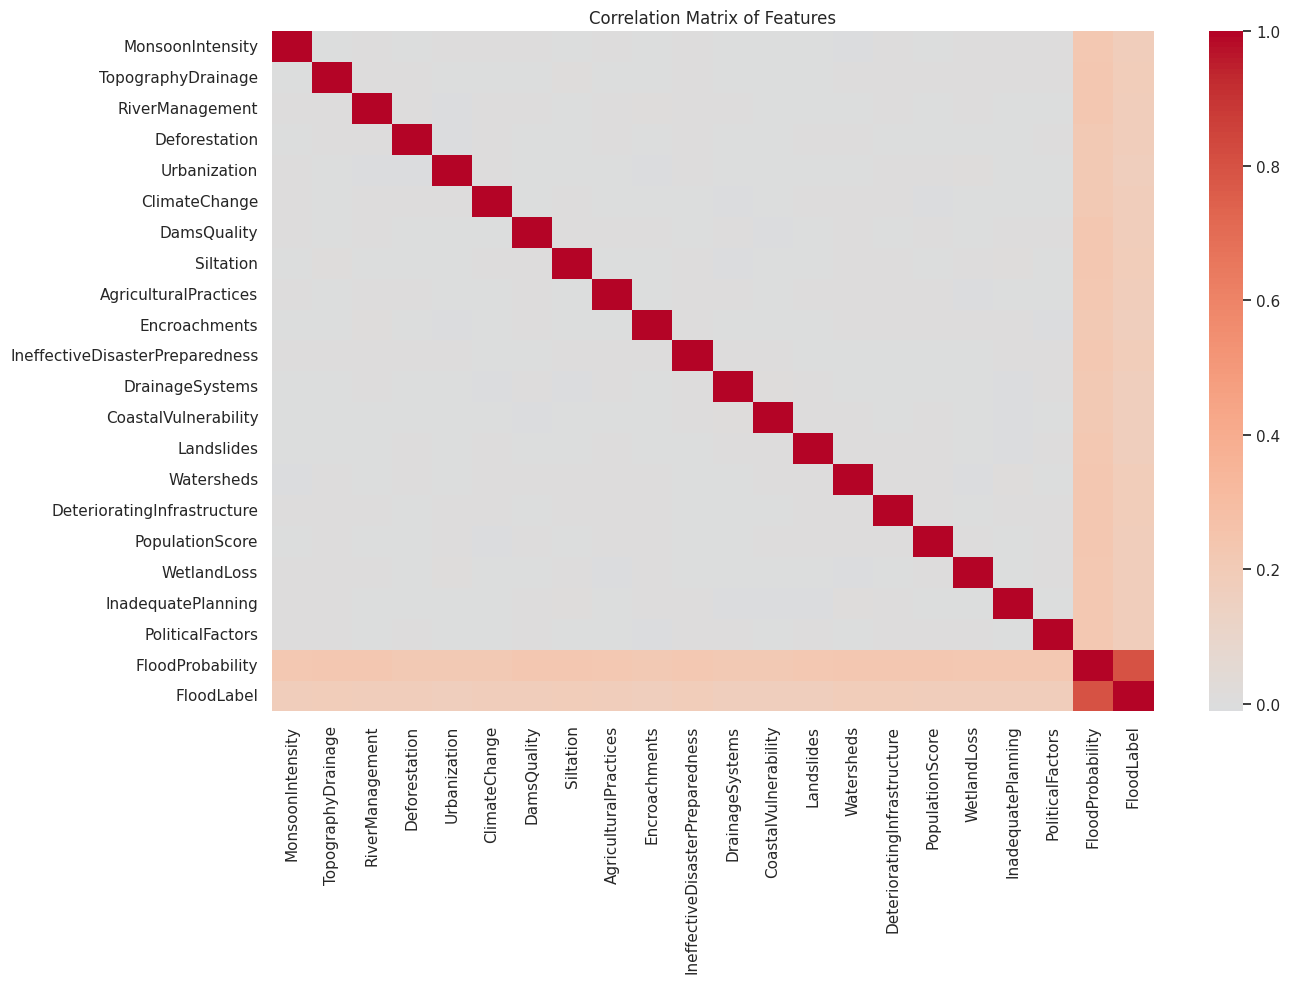

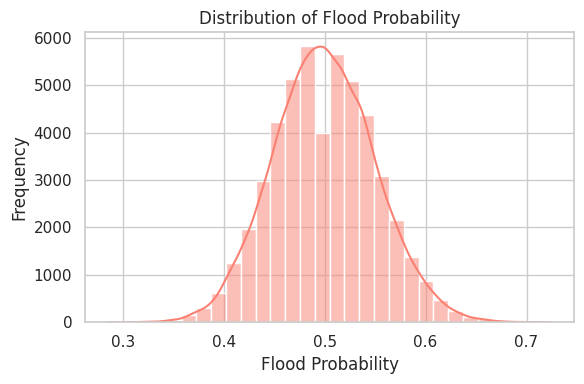

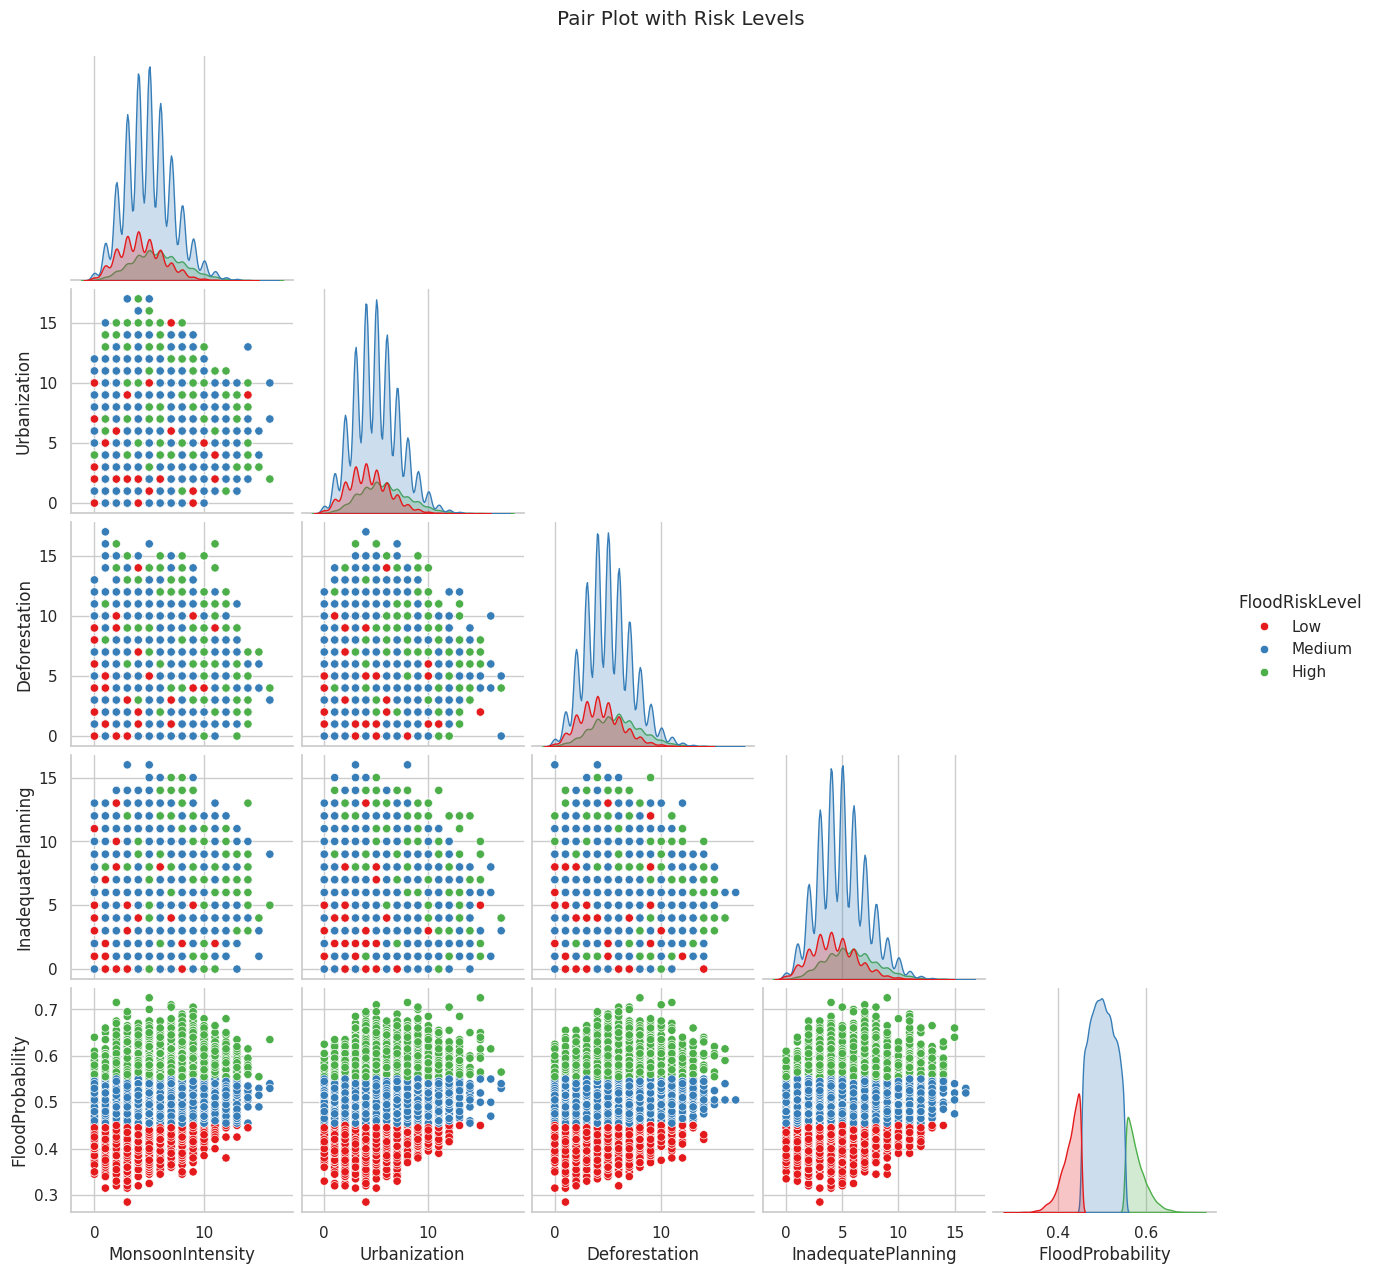

In [ ]:
# 1. Correlation Matrix
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()

# 3. Distribution of Flood Probability
plt.figure(figsize=(6, 4))
sns.histplot(df["FloodProbability"], bins=30, kde=True, color='salmon')
plt.title("Distribution of Flood Probability")
plt.xlabel("Flood Probability")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Select a subset of features for readability
pairplot_features = [
    'MonsoonIntensity', 'Urbanization', 'Deforestation', 'InadequatePlanning', 'FloodProbability'
]

# Create categorical bins of FloodProbability
df['FloodRiskLevel'] = pd.cut(df['FloodProbability'], bins=[0, 0.45, 0.55, 1.0], labels=['Low', 'Medium', 'High'])

# Pair plot with hue
sns.pairplot(df[pairplot_features + ['FloodRiskLevel']], hue='FloodRiskLevel', corner=True, palette='Set1')
plt.suptitle("Pair Plot with Risk Levels", y=1.02)
plt.show()


In [ ]:
# 🌲 Train Random Forest Model (Parallel)
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
# 📉 Overfitting vs Underfitting Check

from sklearn.metrics import accuracy_score, f1_score

# Predictions on training data
train_pred = rf.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
train_f1 = f1_score(y_train, train_pred)

# Predictions on test data
test_pred = rf.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred)

# Results
print(f"🧪 Training Accuracy: {train_acc:.4f}")
print(f"🧪 Training F1 Score: {train_f1:.4f}")
print(f"🧪 Testing Accuracy: {test_acc:.4f}")
print(f"🧪 Testing F1 Score: {test_f1:.4f}")

# Basic Interpretation
if train_acc - test_acc > 0.1:
    print("⚠️ Likely Overfitting")
elif train_acc < 0.7 and test_acc < 0.7:
    print("⚠️ Likely Underfitting")
else:
    print("✅ Model is Generalizing Well")


🧪 Training Accuracy: 1.0000
🧪 Training F1 Score: 1.0000
🧪 Testing Accuracy: 0.8994
🧪 Testing F1 Score: 0.8999
⚠️ Likely Overfitting


In [ ]:
# 🧪 Predictions and Evaluation
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")


✅ Accuracy: 0.8994
✅ F1 Score: 0.8999
✅ ROC AUC: 0.9688


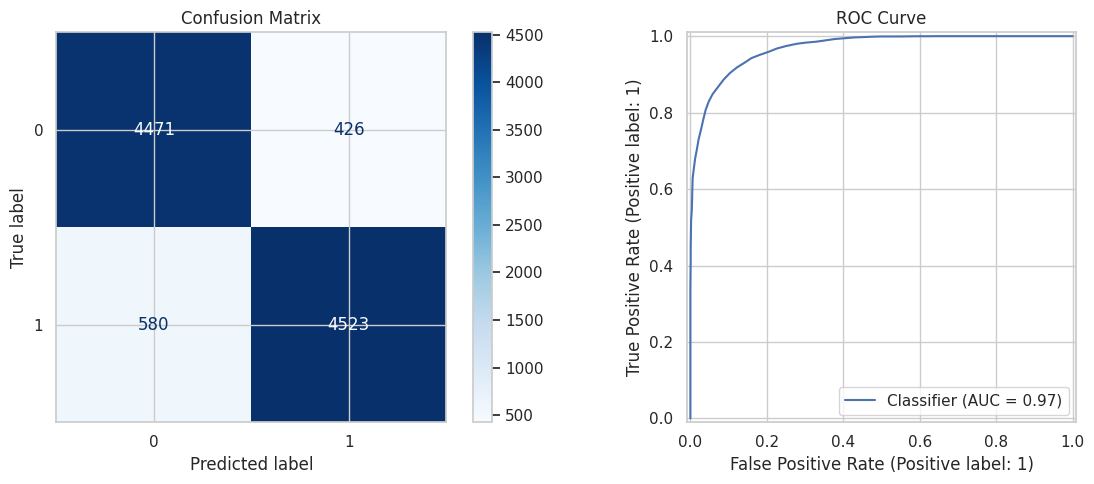

In [ ]:
# 📊 Visualization: Confusion Matrix & ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0], cmap="Blues")
ax[0].set_title("Confusion Matrix")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax[1])
ax[1].set_title("ROC Curve")

plt.tight_layout()
plt.show()


/tmp/ipython-input-62-369189345.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


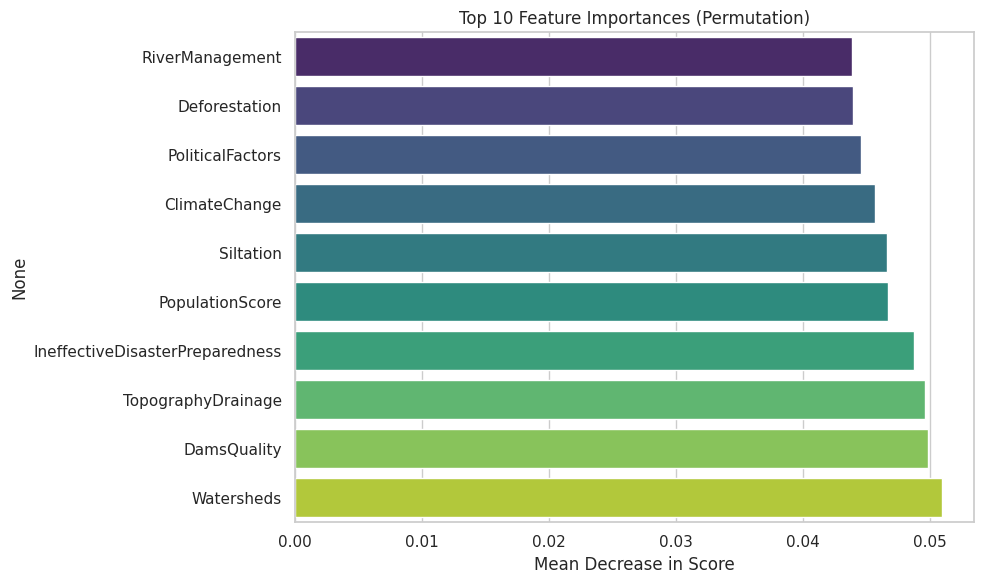

In [ ]:
# 🧠 Feature Importance (Permutation-based)
result = permutation_importance(
    rf, X_test, y_test,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

sorted_idx = result.importances_mean.argsort()[-10:]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=result.importances_mean[sorted_idx],
    y=X_test.columns[sorted_idx],
    palette='viridis'
)
plt.title("Top 10 Feature Importances (Permutation)")
plt.xlabel("Mean Decrease in Score")
plt.tight_layout()
plt.show()


In [ ]:
#model comparison
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("LR Accuracy:", accuracy_score(y_test, lr.predict(X_test)))


LR Accuracy: 1.0


In [ ]:
import time
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Optional: Synthetic dataset boost for clearer benchmarking
from sklearn.datasets import make_classification

# Number of repetitions for average timing
repeats = 5
# Serial training benchmark
serial_times = []
for _ in range(repeats):
    start = time.time()
    rf_serial = RandomForestClassifier(n_estimators=200, n_jobs=1, random_state=42)
    rf_serial.fit(X_train, y_train)
    serial_times.append(time.time() - start)

# Parallel training benchmark
parallel_times = []
for _ in range(repeats):
    start = time.time()
    rf_parallel = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
    rf_parallel.fit(X_train, y_train)
    parallel_times.append(time.time() - start)

# Show average results
avg_serial = np.mean(serial_times)
avg_parallel = np.mean(parallel_times)
speedup = avg_serial / avg_parallel

print(f"🧵 Avg Serial Training Time over {repeats} runs: {avg_serial:.4f} seconds")
print(f"⚡ Avg Parallel Training Time over {repeats} runs: {avg_parallel:.4f} seconds")
print(f"🚀 Speedup from parallelization: {speedup:.2f}x")

if avg_parallel < avg_serial:
    print("✅ Parallel training is faster ✅")
else:
    print("⚠️ Parallel training is slower ⚠️")



🧵 Avg Serial Training Time over 5 runs: 12.2779 seconds
⚡ Avg Parallel Training Time over 5 runs: 9.5414 seconds
🚀 Speedup from parallelization: 1.29x
✅ Parallel training is faster ✅
